In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
df= pd.read_csv("chatgpt_style_reviews_dataset.csv")

In [4]:
df.head()

,date,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase
0,2024-09-06,Claim who accept.,Every quite sense including six lot have never...,4,morrowthomas,30,22,Flipkart,ar,Nepal,3.8.4,No
1,3/7/2025,Growth pretty wish.,Ask develop bag also his worker pass. Expert w...,4,sheakimberly,120,22,Flipkart,ar,Guinea,5.2.6,Yes
2,########,What then spend offer reason whom none.,If customer address region try near risk next ...,5,katherineali,130,21,Flipkart,es,Kuwait,3.6.5,No
3,########,Say dog drug enter director strong student.,To television loss election him small detail r...,1,eric11,72,26,Amazon,pt,Uruguay,5.7.2,No
4,########,Purpose here beyond.,Pass share must amount lot per manage world to...,5,chloe42,123,27,Amazon,zh,Mayotte,5.8.6,No


In [5]:
df.shape

(250, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               250 non-null    object
 1   title              250 non-null    object
 2   review             250 non-null    object
 3   rating             250 non-null    int64 
 4   username           250 non-null    object
 5   helpful_votes      250 non-null    int64 
 6   review_length      250 non-null    int64 
 7   platform           250 non-null    object
 8   language           250 non-null    object
 9   location           250 non-null    object
 10  version            250 non-null    object
 11  verified_purchase  250 non-null    object
dtypes: int64(3), object(9)
memory usage: 23.6+ KB


In [7]:
df.describe()

,rating,helpful_votes,review_length
count,250.000000,250.000000,250.000000
mean,2.980000,94.416000,20.852000
std,1.465671,57.020842,3.459185
min,1.000000,0.000000,13.000000
25%,2.000000,42.250000,18.000000
50%,3.000000,95.000000,21.000000
75%,4.000000,140.500000,23.000000
max,5.000000,200.000000,29.000000


In [8]:
df.describe(include='object')

,date,title,review,username,platform,language,location,version,verified_purchase
count,250,250,250,250,250,250,250,250,250
unique,49,250,250,250,5,10,157,197,2
top,########,Claim who accept.,Every quite sense including six lot have never...,morrowthomas,Amazon,ru,Congo,5.9.6,No
freq,192,1,1,1,56,27,6,3,134


In [9]:
df.drop_duplicates(inplace=True)

In [ ]:
df['date'].value_counts()

In [10]:
df.drop(['date'],axis=1,inplace=True)

In [11]:
df['rating'].value_counts()

rating
1    59
3    57
5    55
4    41
2    38
Name: count, dtype: int64

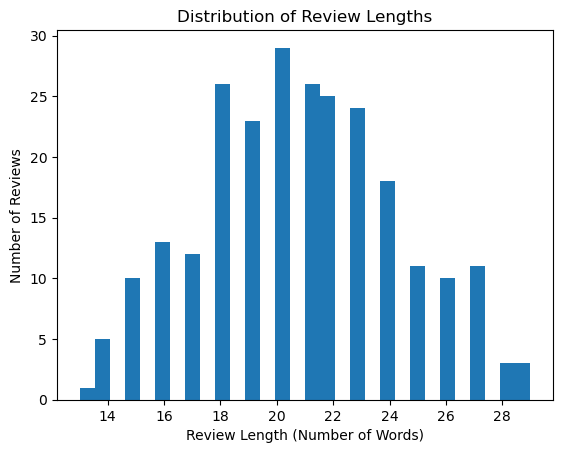

In [12]:
#Review length
plt.figure()
plt.hist(df['review_length'], bins=30)
plt.xlabel("Review Length (Number of Words)")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Review Lengths")
plt.show()


In [13]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = [word for word in text.split() if word not in stop_words]
    return " ".join(words)

df['clean_review'] = df['review'].apply(preprocess_text)

df['verified_purchase'] = df['verified_purchase'].map({'Yes': 1, 'No': 0})

print(df.head())

                                         title  \
0                            Claim who accept.   
1                          Growth pretty wish.   
2      What then spend offer reason whom none.   
3  Say dog drug enter director strong student.   
4                         Purpose here beyond.   

                                              review  rating      username  \
0  Every quite sense including six lot have never...       4  morrowthomas   
1  Ask develop bag also his worker pass. Expert w...       4  sheakimberly   
2  If customer address region try near risk next ...       5  katherineali   
3  To television loss election him small detail r...       1        eric11   
4  Pass share must amount lot per manage world to...       5       chloe42   

   helpful_votes  review_length  platform language location version  \
0             30             22  Flipkart       ar    Nepal   3.8.4   
1            120             22  Flipkart       ar   Guinea   5.2.6   
2            130 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91944\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


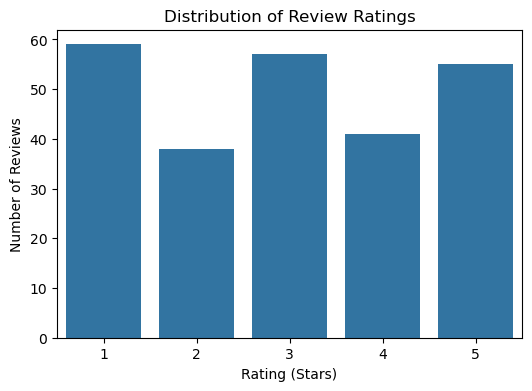

In [14]:
#EDA Analysis
#What is the distribution of review ratings?

plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=df, order=[1,2,3,4,5])
plt.title("Distribution of Review Ratings")
plt.xlabel("Rating (Stars)")
plt.ylabel("Number of Reviews")
plt.show()


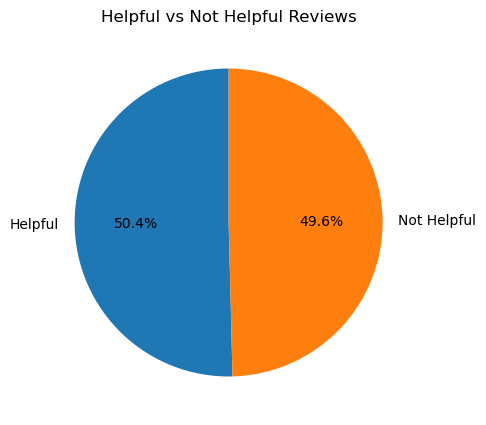

In [15]:
# How many reviews were marked as helpful (above a certain threshold)?

threshold = df['helpful_votes'].median()

df['helpful_status'] = df['helpful_votes'].apply(
    lambda x: 'Helpful' if x >= threshold else 'Not Helpful'
)
counts = df['helpful_status'].value_counts()

plt.figure(figsize=(5,5))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Helpful vs Not Helpful Reviews")
plt.show()

In [16]:
# What are the most common keywords in positive vs. negative reviews?

def get_sentiment(rating):
    if rating >= 4:
        return "Positive"
    elif rating == 3:
        return "Neutral"
    else:
        return "Negative"

df['sentiment'] = df['rating'].apply(get_sentiment)


In [17]:
pip install wordcloud


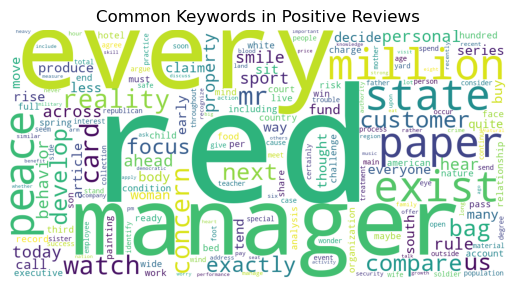

In [19]:
positive_text = " ".join(df[df['sentiment'] == 'Positive']['clean_review'])
negative_text = " ".join(df[df['sentiment'] == 'Negative']['clean_review'])

wordcloud_positive = WordCloud(
    width=1000,
    height=500,
    background_color='white'
).generate(positive_text)

plt.figure()
plt.imshow(wordcloud_positive)
plt.axis('off')
plt.title("Common Keywords in Positive Reviews")
plt.show()


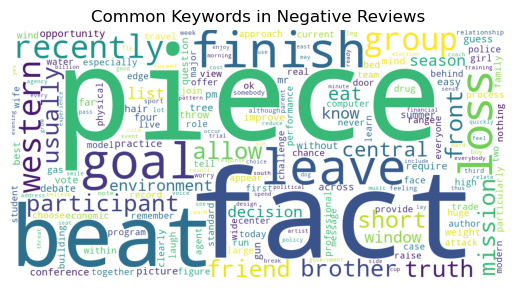

In [20]:
wordcloud_negative = WordCloud(
    width=1000,
    height=500,
    background_color='white'
).generate(negative_text)

plt.figure()
plt.imshow(wordcloud_negative)
plt.axis('off')
plt.title("Common Keywords in Negative Reviews")
plt.show()


In [21]:
# How do ratings vary by user location?
df['location'].value_counts()

location
Congo                                                  6
Saudi Arabia                                           5
Christmas Island                                       5
British Indian Ocean Territory (Chagos Archipelago)    5
Luxembourg                                             5
                                                      ..
Puerto Rico                                            1
Niue                                                   1
Saint Barthelemy                                       1
Iran                                                   1
Turkmenistan                                           1
Name: count, Length: 157, dtype: int64

In [22]:
region_map = {

    # 🌏 ASIA
    'Nepal': 'Asia',
    'Kuwait': 'Middle East',
    'Brunei Darussalam': 'Asia',
    'Armenia': 'Asia',
    'Vietnam': 'Asia',
    'Saudi Arabia': 'Middle East',
    'Mongolia': 'Asia',
    'Palestinian Territory': 'Middle East',
    'Lebanon': 'Middle East',
    'Cambodia': 'Asia',
    'Azerbaijan': 'Asia',
    'Afghanistan': 'Asia',
    'China': 'Asia',
    'Malaysia': 'Asia',
    'Philippines': 'Asia',
    'Taiwan': 'Asia',
    'Yemen': 'Middle East',
    'Iraq': 'Middle East',
    'United Arab Emirates': 'Middle East',
    'Israel': 'Middle East',
    'Iran': 'Middle East',
    'Turkmenistan': 'Asia',
    'Tajikistan': 'Asia',
    'Timor-Leste': 'Asia',
    'Bhutan': 'Asia',
    'Oman': 'Middle East',
    'Georgia': 'Asia',
    'Korea': 'Asia',

    # 🌍 EUROPE
    'Italy': 'Europe',
    'Luxembourg': 'Europe',
    'Estonia': 'Europe',
    'Austria': 'Europe',
    'Poland': 'Europe',
    'Isle of Man': 'Europe',
    'Latvia': 'Europe',
    'Cyprus': 'Europe',
    'Moldova': 'Europe',
    'Holy See (Vatican City State)': 'Europe',
    'Macedonia': 'Europe',
    'Bosnia and Herzegovina': 'Europe',
    'Belarus': 'Europe',
    'Romania': 'Europe',
    'Norway': 'Europe',
    'France': 'Europe',
    'Montenegro': 'Europe',
    'Ireland': 'Europe',
    'Portugal': 'Europe',
    'Greece': 'Europe',
    'Spain': 'Europe',
    'Czech Republic': 'Europe',
    'Monaco': 'Europe',
    'Belgium': 'Europe',
    'Hungary': 'Europe',
    'Albania': 'Europe',
    'Slovakia (Slovak Republic)': 'Europe',
    'Serbia': 'Europe',
    'Iceland': 'Europe',
    'Ukraine': 'Europe',

    # 🌍 AFRICA
    'Guinea': 'Africa',
    'Burkina Faso': 'Africa',
    'Kenya': 'Africa',
    'Rwanda': 'Africa',
    'Libyan Arab Jamahiriya': 'Africa',
    'Tunisia': 'Africa',
    'Sudan': 'Africa',
    'Nigeria': 'Africa',
    'Benin': 'Africa',
    'Sierra Leone': 'Africa',
    'Central African Republic': 'Africa',
    'Uganda': 'Africa',
    'Zimbabwe': 'Africa',
    'Malawi': 'Africa',
    'Niger': 'Africa',
    'Algeria': 'Africa',
    'Namibia': 'Africa',
    'Mauritania': 'Africa',
    'Cameroon': 'Africa',
    'Egypt': 'Africa',
    'Ethiopia': 'Africa',
    'Swaziland': 'Africa',
    'Chad': 'Africa',
    'Botswana': 'Africa',
    'Angola': 'Africa',
    'Madagascar': 'Africa',
    'Eritrea': 'Africa',
    'Comoros': 'Africa',

    # 🌎 NORTH AMERICA
    'Bahamas': 'North America',
    'British Virgin Islands': 'North America',
    'Saint Lucia': 'North America',
    'Antigua and Barbuda': 'North America',
    'Dominican Republic': 'North America',
    'Mexico': 'North America',
    'Saint Kitts and Nevis': 'North America',
    'Honduras': 'North America',
    'Panama': 'North America',
    'Dominica': 'North America',
    'Canada': 'North America',
    'United States of America': 'North America',
    'United States Virgin Islands': 'North America',
    'Grenada': 'North America',
    'Anguilla': 'North America',
    'Belize': 'North America',
    'Puerto Rico': 'North America',
    'Montserrat': 'North America',
    'Haiti': 'North America',
    'Guatemala': 'North America',

    # 🌎 SOUTH AMERICA
    'Uruguay': 'South America',
    'Paraguay': 'South America',
    'Venezuela': 'South America',
    'Ecuador': 'South America',
    'Colombia': 'South America',
    'Peru': 'South America',
    'Bolivia': 'South America',
    'Argentina': 'South America',

    # 🌊 OCEANIA
    'Micronesia': 'Oceania',
    'Nauru': 'Oceania',
    'Guam': 'Oceania',
    'Vanuatu': 'Oceania',
    'French Polynesia': 'Oceania',
    'Northern Mariana Islands': 'Oceania',
    'Solomon Islands': 'Oceania',
    'Tuvalu': 'Oceania',
    'Wallis and Futuna': 'Oceania',
    'Tokelau': 'Oceania',
    'Norfolk Island': 'Oceania',
    'Kiribati': 'Oceania',
    'Papua New Guinea': 'Oceania',
    'Samoa': 'Oceania',
    'Fiji': 'Oceania',
    'Niue': 'Oceania',
    'Australia': 'Oceania',
    'Tonga': 'Oceania',

    # 🌐 OTHER / TERRITORIES
    'Greenland': 'Other',
    'Mayotte': 'Other',
    'Christmas Island': 'Other',
    'British Indian Ocean Territory (Chagos Archipelago)': 'Other',
    'Guadeloupe': 'Other',
    'Martinique': 'Other',
    'Netherlands Antilles': 'Other',
    'Heard Island and McDonald Islands': 'Other',
    'Bouvet Island (Bouvetoya)': 'Other',
    'Saint Helena': 'Other',
    'New Caledonia': 'Other',
    'French Southern Territories': 'Other',
    'United States Minor Outlying Islands': 'Other',
    'Gibraltar': 'Other',
    'Saint Barthelemy': 'Other'
}


In [23]:
df['region'] = df['location'].map(region_map)
df['region'] = df['region'].fillna('Other')
df['region'].value_counts()

region
Other            49
Europe           46
Africa           39
Asia             30
North America    27
Oceania          26
Middle East      18
South America    15
Name: count, dtype: int64

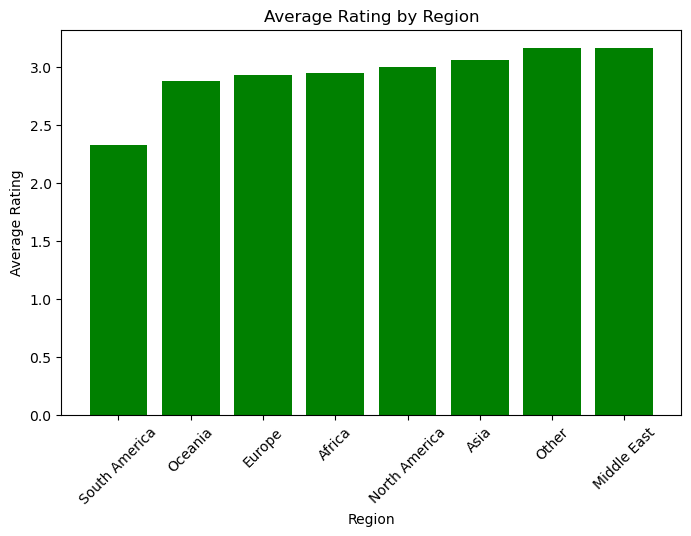

In [24]:
region_avg_rating =df.groupby('region')['rating'].mean().sort_values()

plt.figure(figsize=(8,5))
plt.bar(region_avg_rating.index, region_avg_rating.values,color='green')
plt.xlabel("Region")
plt.ylabel("Average Rating")
plt.title("Average Rating by Region")
plt.xticks(rotation=45)
plt.show()


In [25]:
#Which platform (Web vs Mobile) gets better reviews?
df['platform'].value_counts()

platform
Amazon         56
App Store      55
Website        54
Flipkart       44
Google Play    41
Name: count, dtype: int64

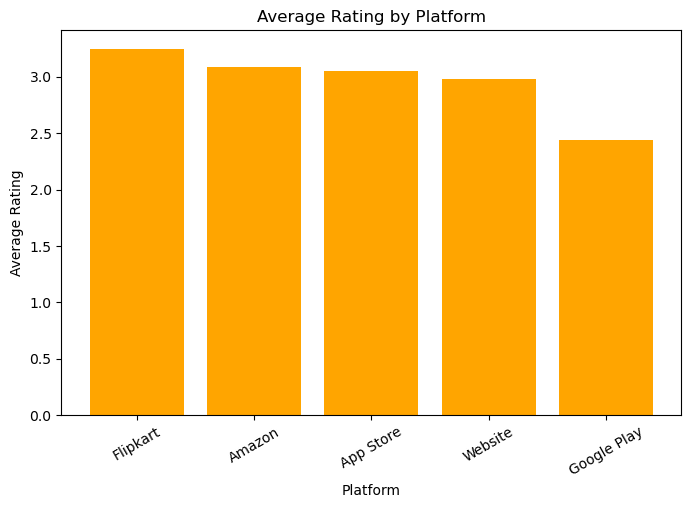

In [26]:
platform_avg_rating = df.groupby('platform')['rating'].mean().sort_values(ascending=False)
platform_avg_rating



plt.figure(figsize=(8,5))
plt.bar(platform_avg_rating.index, platform_avg_rating.values,color='orange')
plt.xlabel("Platform")
plt.ylabel("Average Rating")
plt.title("Average Rating by Platform")
plt.xticks(rotation=30)
plt.show()

In [27]:
# Are verified users more satisfied than non-verified ones?
df['verified_purchase'].value_counts()


verified_purchase
0    134
1    116
Name: count, dtype: int64

In [28]:
verified_rating = df.groupby('verified_purchase')['rating'].mean()
verified_rating


verified_purchase
0    2.955224
1    3.008621
Name: rating, dtype: float64

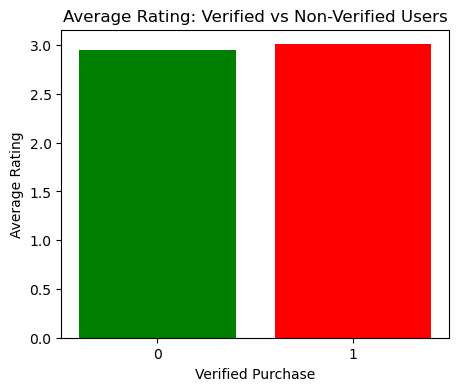

In [29]:
plt.figure(figsize=(5,4))
plt.bar(verified_rating.index.astype(str), verified_rating.values,color=['green', 'red'])
plt.xlabel("Verified Purchase")
plt.ylabel("Average Rating")
plt.title("Average Rating: Verified vs Non-Verified Users")
plt.show()


In [30]:
#What’s the average length of reviews per rating category?
df['review_length'] = df['clean_review'].str.split().str.len()
avg_length_by_rating = df.groupby('rating')['review_length'].mean()
avg_length_by_rating


rating
1    18.305085
2    20.500000
3    17.947368
4    18.853659
5    19.200000
Name: review_length, dtype: float64

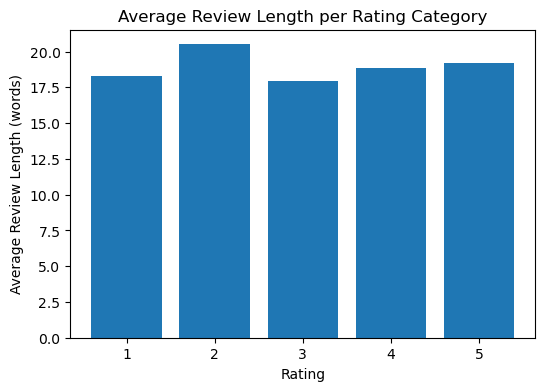

In [31]:
plt.figure(figsize=(6,4))
plt.bar(avg_length_by_rating.index, avg_length_by_rating.values)
plt.xlabel("Rating")
plt.ylabel("Average Review Length (words)")
plt.title("Average Review Length per Rating Category")
plt.show()

In [32]:
#What are the most mentioned words in 1-star reviews?
one_star_reviews = df[df['rating'] == 1]['clean_review']
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

cleaned_text = one_star_reviews.apply(clean_text)


In [33]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

text_1star = " ".join(
    word for review in cleaned_text
    for word in review.split()
    if word not in stop_words and len(word) > 2
)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91944\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


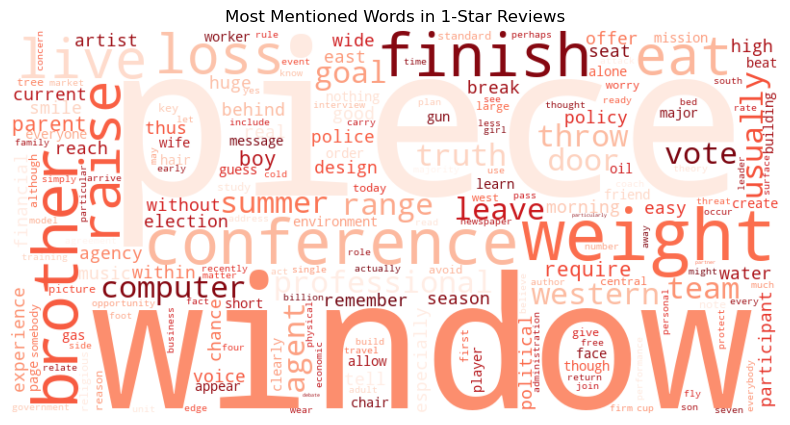

In [34]:
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds'
).generate(text_1star)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Mentioned Words in 1-Star Reviews")
plt.show()


In [35]:
#What ChatGPT version received the highest average rating?
df['version'].value_counts()

version
5.9.6    3
1.4.7    3
4.7.3    3
3.0.6    3
2.1.7    3
        ..
2.3.8    1
1.9.3    1
2.3.4    1
3.9.6    1
3.1.3    1
Name: count, Length: 197, dtype: int64

In [36]:
# Extract the first number as major version
df['major_version'] = df['version'].str.split('.').str[0]
avg_rating_major = df.groupby('major_version')['rating'].mean().sort_index()
avg_rating_major

major_version
1    3.142857
2    2.734694
3    3.153846
4    2.904762
5    3.000000
Name: rating, dtype: float64

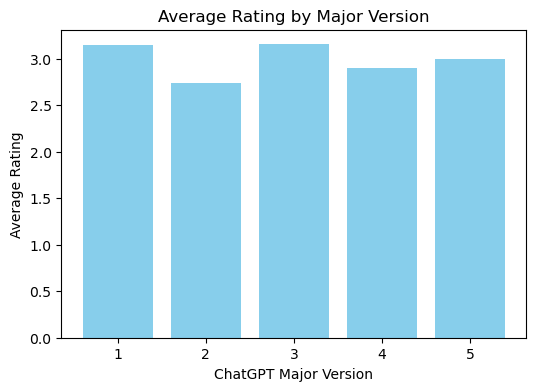

In [37]:
plt.figure(figsize=(6,4))
plt.bar(avg_rating_major.index, avg_rating_major.values, color='skyblue')
plt.xlabel("ChatGPT Major Version")
plt.ylabel("Average Rating")
plt.title("Average Rating by Major Version")
plt.show()

In [38]:
df['sentiment']= df['sentiment'].map({"Negative": -1,"Neutral": 0,"Positive": 1})

In [39]:
df.head()

,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase,clean_review,helpful_status,sentiment,region,major_version
0,Claim who accept.,Every quite sense including six lot have never...,4,morrowthomas,30,21,Flipkart,ar,Nepal,3.8.4,0,every quite sense including six lot never effe...,Not Helpful,1,Asia,3
1,Growth pretty wish.,Ask develop bag also his worker pass. Expert w...,4,sheakimberly,120,21,Flipkart,ar,Guinea,5.2.6,1,ask develop bag also worker pass expert white ...,Helpful,1,Africa,5
2,What then spend offer reason whom none.,If customer address region try near risk next ...,5,katherineali,130,19,Flipkart,es,Kuwait,3.6.5,0,customer address region try near risk next gir...,Helpful,1,Middle East,3
3,Say dog drug enter director strong student.,To television loss election him small detail r...,1,eric11,72,24,Amazon,pt,Uruguay,5.7.2,0,television loss election small detail red son ...,Not Helpful,-1,South America,5
4,Purpose here beyond.,Pass share must amount lot per manage world to...,5,chloe42,123,24,Amazon,zh,Mayotte,5.8.6,0,pass share must amount lot per manage world ma...,Helpful,1,Other,5


In [40]:
df['sentiment'].value_counts()

sentiment
-1    97
 1    96
 0    57
Name: count, dtype: int64

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

x = vectorizer.fit_transform(df['clean_review'])
y = df['sentiment']

In [42]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [43]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

LogisticRegression()

In [44]:
y_pred = lr.predict(x_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Test Accuracy: 0.4
              precision    recall  f1-score   support

          -1       0.43      0.45      0.44        20
           0       0.00      0.00      0.00        12
           1       0.38      0.61      0.47        18

    accuracy                           0.40        50
   macro avg       0.27      0.35      0.30        50
weighted avg       0.31      0.40      0.34        50

[[ 9  0 11]
 [ 5  0  7]
 [ 7  0 11]]


C:\Users\91944\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\91944\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\91944\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [45]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

In [46]:
y_pred = rf.predict(x_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.48
              precision    recall  f1-score   support

          -1       0.50      0.60      0.55        20
           0       0.00      0.00      0.00        12
           1       0.46      0.67      0.55        18

    accuracy                           0.48        50
   macro avg       0.32      0.42      0.36        50
weighted avg       0.37      0.48      0.41        50

[[12  0  8]
 [ 6  0  6]
 [ 6  0 12]]


C:\Users\91944\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\91944\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\91944\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [47]:
df_bin = df[df['rating'] != 3].copy()
df_bin['sentiment'] = df_bin['rating'].apply(
    lambda x: 0 if x <= 2 else 1
)

In [48]:
df_bin['sentiment'].value_counts()

sentiment
0    97
1    96
Name: count, dtype: int64

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer= TfidfVectorizer(
    analyzer='char', 
    max_features=1000,
    ngram_range=(3,5),
    min_df=3,
 )

In [60]:
X = vectorizer.fit_transform(df_bin['clean_review'])
y = df_bin['sentiment']


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42, stratify=y)

In [62]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [63]:
y_pred = lr.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.5641025641025641
              precision    recall  f1-score   support

           0       0.58      0.55      0.56        20
           1       0.55      0.58      0.56        19

    accuracy                           0.56        39
   macro avg       0.56      0.56      0.56        39
weighted avg       0.56      0.56      0.56        39

[[11  9]
 [ 8 11]]


In [64]:
model = LinearSVC()
model.fit(X_train, y_train)

LinearSVC()

In [65]:
y_pred = model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.5128205128205128
              precision    recall  f1-score   support

           0       0.53      0.45      0.49        20
           1       0.50      0.58      0.54        19

    accuracy                           0.51        39
   macro avg       0.51      0.51      0.51        39
weighted avg       0.52      0.51      0.51        39

[[ 9 11]
 [ 8 11]]


In [66]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [67]:
y_pred = rf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.6410256410256411
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        20
           1       0.62      0.68      0.65        19

    accuracy                           0.64        39
   macro avg       0.64      0.64      0.64        39
weighted avg       0.64      0.64      0.64        39

[[12  8]
 [ 6 13]]


In [69]:
from sklearn.metrics import roc_curve , roc_auc_score
y_prob = rf.predict_proba(X_test)

fpr,tpr,thresholds = roc_curve(y_test,y_prob[:,1])
auc_score = roc_auc_score(y_test,y_prob[:,1])

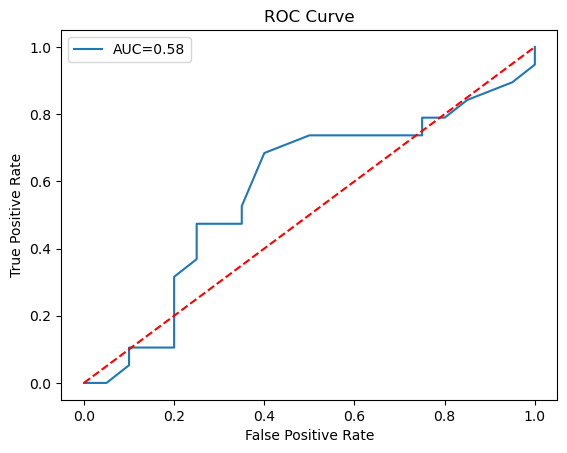

In [70]:
plt.plot(fpr,tpr,label=f'AUC={auc_score:.2f}')
plt.plot([0,1],[0,1],linestyle='--',color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [72]:
from sklearn.pipeline import Pipeline
import pickle
pipeline = Pipeline([
    ("vectorizer",vectorizer ),
    ("model", rf)
])

pickle.dump(pipeline, open("sentiment_pipeline.pkl", "wb"))
